In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf
import pmdarima as pm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Aquisição dos dados

|Country|Index|Ticker|
|---        |---        |---        |
|Brazil|iBovespa|^BVSP|
|USA|Nasdaq Composite|^IXIC|
|USA|NYSE Composite|^NYA|
|USA|Dow Jones|^DJI|
|Argentina|Merval|M.BA|
|Japan|Nikkei 225|^N225|
|China|Shangai Composite|000001.SS|
|China|Hang Seng|^HSI|
|India|BSE 30 Sensex|^BSESN|
|UK|FTSE 100|^FTSE|
|Sweden|Stockholm General|^OMX|
|Germany|Dax|^GDAXI|
|France|Cac 40|^FCHI|

In [4]:
start_date = "2011-01-01"
end_date = "2021-05-31"

df_ibovespa = yf.download('^BVSP', start=start_date, end=end_date)

# Indices de bolsas:
# ^BVSP
# ^IXIC
# ^NYA
# ^DJI
# M.BA
# ^N225
# 000001.SS
# ^HSI
# ^BSESN
# ^FTSE
# ^OMX
# ^GDAXI
# ^FCHI


[*********************100%***********************]  1 of 1 completed


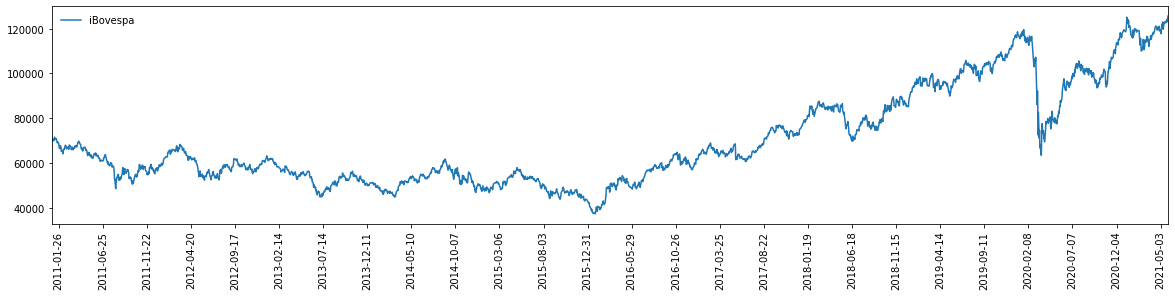

In [6]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_ibovespa['Close'], label="iBovespa")

date_min = df_ibovespa.index.min()
date_max = df_ibovespa.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (01/01/2011 até 30/04/2021) e de validação do modelo (01/05/2021 até 30/05/2021).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [118]:

X_train = df_ibovespa[:"2021-05-01"]
X_test = df_ibovespa["2021-05-01":]
# X_train = df_ibovespa[:-Ntest]
# X_test = df_ibovespa[-Ntest:]

print(f"""Base original: {df_ibovespa.shape}
X_train: {X_train.shape}
X_test: {X_test.shape}\n""")
Ntest = X_test.shape[0]

X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
df_ibovespa["rt"] = (np.log(df_ibovespa["Close"]) - np.log(df_ibovespa["Close"].shift(periods=1)))*100
X_train = X_train[["Close", "rt"]][1:]
X_train.head()

Base original: (2570, 7)
X_train: (2550, 7)
X_test: (20, 7)



,Close,rt
Date,,
2011-01-04,70318.0,0.507557
2011-01-05,71091.0,1.093293
2011-01-06,70579.0,-0.722810
2011-01-07,70057.0,-0.742345
2011-01-10,70127.0,0.099869


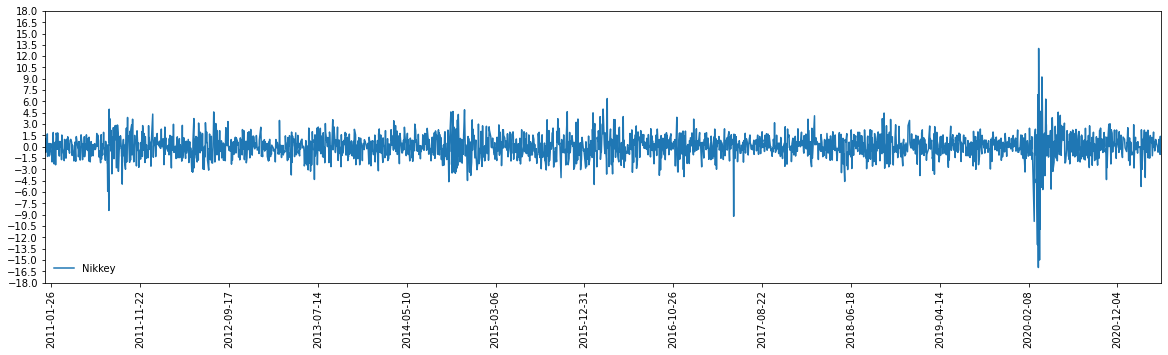

In [119]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = X_train.index.min()
date_max = X_train.index.max()

ax.plot(X_train['rt'], label="Nikkey")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

count    2549.000000
mean        0.020803
std         1.623617
min       -15.993027
25%        -0.827695
50%         0.028816
75%         0.907887
max        13.022281
Name: rt, dtype: float64

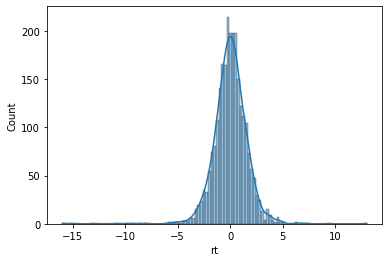

In [120]:
sns.histplot(data=X_train, x="rt", kde=True);
X_train['rt'].describe().T

### ARIMA



In [121]:
X_train

,Close,rt
Date,,
2011-01-04,70318.0,0.507557
2011-01-05,71091.0,1.093293
2011-01-06,70579.0,-0.722810
2011-01-07,70057.0,-0.742345
2011-01-10,70127.0,0.099869
...,...,...
2021-04-26,120595.0,0.053914
2021-04-27,119388.0,-1.005913
2021-04-28,121053.0,1.384977


In [122]:
model = pm.auto_arima(X_train['rt'], erro_action='ignore', trace=True, suppress_warnings=True, maxinter=10, stepwise=False, seasonal=False)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9705.945, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9686.742, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9683.011, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=9684.752, Time=0.25 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=9686.674, Time=0.31 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=9684.360, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9684.908, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9684.166, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9684.848, Time=0.49 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=9686.744, Time=0.48 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=9674.691, Time=0.81 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9683.032, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9685.004, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9651.289, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=9653.223, Time=1.15 sec
 ARIMA(3,0

In [123]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2549
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -4820.645
Date:                Sat, 05 Jun 2021   AIC                           9651.289
Time:                        17:26:24   BIC                           9680.507
Sample:                             0   HQIC                          9661.886
                               - 2549                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6384      0.028    -59.193      0.000      -1.693      -1.584
ar.L2         -0.8152      0.029    -28.416      0.000      -0.871      -0.759
ma.L1          1.5568      0.033     47.832      0.000       1.493       1.621
ma.L2          0.7240      0.034     21.178      0.000       0.657       0.791
sigma2         2.5714      0.030     85.624      0.000       2.513       2.630
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12719.66
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 0, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [125]:
def plot_result(model, fulldata, train, test):
    params = model.get_params()
    d = params['order'][1]

    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fulldata.index, fulldata, label='data')
    ax.plot(train.index[d:], train_pred, label='fitted')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[0:,1], color='red', alpha=0.3)
    ax.legend();

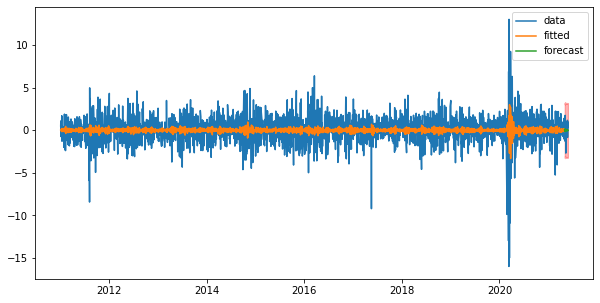

In [126]:
plot_result(model, df_ibovespa["rt"], X_train['rt'], X_test['rt'])

In [127]:
def plot_test(model, test):
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(test.index, test, label='true')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[0:,1], color='red', alpha=0.3)
    ax.legend();

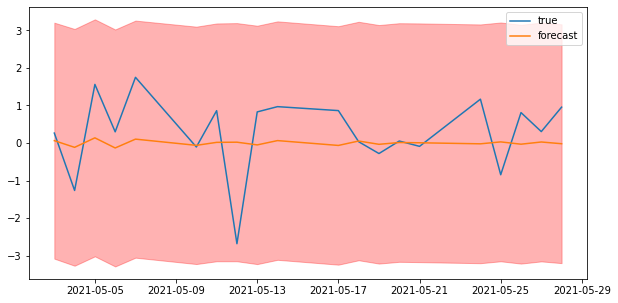

In [128]:
plot_test(model, X_test['rt'])

In [129]:
def rmse(y, t):
    return np.sqrt(np.mean((t - y)**2))

In [130]:
predictions = model.predict(Ntest)
# predictions2 = predictions.reshape(Ntest,1)

In [131]:
# predictions2= predictions2.reshape(1,-1)[0]

In [132]:
print("RSME ARIMA:", rmse(predictions, X_test["rt"]))
print("RSME Naive:", rmse(X_train['rt'].iloc[-1], X_test['rt']))

RSME ARIMA: 1.0184629864010233
RSME Naive: 1.6023655493456637


In [ ]:
## Achando a estrutura da rede